# Let’s try using the Trainer feature

By using [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer), you don’t need to write the tedious training loop explicitly any more. Furthermore, Chainer provides many useful extensions that can be used with [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) to visualize your results, evaluate your model, store and manage log files more easily.

This example will show how to use the [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) to train a fully-connected feed-forward neural network on the MNIST dataset.

**Note**

If you would like to know how to write a training loop without using this functionality, please check [How to write a training loop in Chainer](training_loop_in_chainer.ipynb) instead of this tutorial.

First, let's import the necessary packages for using Chainer.

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

# 1. Prepare the dataset

Load the MNIST dataset, which contains a training set of images and class labels as well as a corresponding test set.

In [2]:
from chainer.datasets import mnist

train, test = mnist.get_mnist()

**Note**
You can use a **Python list as a dataset**. Because all types of objects whose element can be accessed via `[]` accessor and lengh can be obtained with `len()` function, can be used as a dataset given to the [Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator). For example,

```
train = [(x1, t1), (x2, t2), ...]
```

a list of tuples like this can also be used equally to a [DatasetMixin](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.DatasetMixin.html#chainer.dataset.DatasetMixin) object.

But many useful abstracted [datasets](https://docs.chainer.org/en/latest/reference/datasets.html#module-chainer.datasets) enable to avoid storing all data on the memory at a time, so it’s better to use them for large datasets. For example, [ImageDataset](https://docs.chainer.org/en/latest/reference/generated/chainer.datasets.ImageDataset.html#chainer.datasets.ImageDataset) takes paths to image files as its argument, and just keep the list in the dataset object. It means the actual image data will be loaded from disks using given paths when [\_\_getitem\_\_()](https://docs.chainer.org/en/latest/reference/generated/chainer.datasets.ImageDataset.html#chainer.datasets.ImageDataset.__getitem__) is called. Until then, no images are loaded to the memory, so it can save the memory consumption.

# 2. Prepare the dataset iterations

[Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator) creates a mini-batch from the given dataset.

In [3]:
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

# 3. Prepare the model

Here, we are going to use the same model as defined in [How to write a training loop in Chainer](1_training_loop_in_chainer.ipynb).

In [4]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = MLP()

# 4. Prepare the Updater

[Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) is a class that holds all of the necessary components needed for training. The main components are shown below.

![](trainer.png)

Basically, all you need to pass to [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) is an [Updater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Updater.html#chainer.training.Updater). However, [Updater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Updater.html#chainer.training.Updater) contains an [Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator) and [Optimizer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Optimizer.html#chainer.Optimizer). Since [Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator) can access the dataset and [Optimizer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Optimizer.html#chainer.Optimizer) has references to the model, [Updater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Updater.html#chainer.training.Updater) can access to the model to update its parameters.

So, [Updater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Updater.html#chainer.training.Updater) can perform the training procedure as shown below:

Retrieve the data from dataset and construct a mini-batch ([Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator))
Pass the mini-batch to the model and calculate the loss
Update the parameters of the model ([Optimizer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Optimizer.html#chainer.Optimizer))

Now let’s create the [Updater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Updater.html#chainer.training.Updater) object !

In [5]:
max_epoch = 10

# Wrapp your model by Classifier and include the process of loss calculation within your model.
# Since we do not specify a loss funciton here, the default 'softmax_cross_entropy' is used.
model = L.Classifier(model)

gpu_id = 0  # Set to -1 if you use CPU
if gpu_id >= 0:
    model.to_gpu(gpu_id)  # If you use CPU, comment out this line

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

**Note**

Here, the model defined above is passed to [Classifier](https://docs.chainer.org/en/latest/reference/generated/chainer.links.Classifier.html#chainer.links.Classifier) and changed to a new [Chain](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain). [Classifier](https://docs.chainer.org/en/latest/reference/generated/chainer.links.Classifier.html#chainer.links.Classifier), which in fact inherits from the [Chain](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain) class, keeps the given [Chain](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain) model in its `predictor` attribute. Once you give the input data and the corresponding class labels to the model by the `()` accessor,

1. [\_\_call\_\_()](https://docs.chainer.org/en/latest/reference/generated/chainer.links.Classifier.html#chainer.links.Classifier.__call__) of the model is invoked. The data is then given to `predictor` to obtain the output `y`.
2. Next, together with the given labels, the output `y` is passed to the loss function which is determined by `lossfun` argument in the constructor of [Classifier](https://docs.chainer.org/en/latest/reference/generated/chainer.links.Classifier.html#chainer.links.Classifier).
The loss is returned as a [Variable](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Variable.html#chainer.Variable).

In [Classifiler](https://docs.chainer.org/en/latest/reference/generated/chainer.links.Classifier.html#chainer.links.Classifier), the `lossfun` is set to [softmax_cross_entropy()](https://docs.chainer.org/en/latest/reference/generated/chainer.functions.softmax_cross_entropy.html#chainer.functions.softmax_cross_entropy) as default.

[StandardUpdater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.StandardUpdater.html#chainer.training.StandardUpdater) is the simplest class among several updaters. There are also the [ParallelUpdater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.ParallelUpdater.html#chainer.training.ParallelUpdater) and the [MultiprocessParallelUpdater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.updaters.MultiprocessParallelUpdater.html#chainer.training.updaters.MultiprocessParallelUpdater) to utilize multiple GPUs.

# 5. Setup Trainer

Lastly, we will setup [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer). The only requirement for creating a [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) is to pass the [Updater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Updater.html#chainer.training.Updater) object that we previously created above. You can also pass a stop_trigger to the second trainer argument as a tuple like `(length, unit)` to tell the trainer when to stop the training. The `length` is given as an integer and the `unit` is given as a string which should be either `'epoch'` or `'iteration'`. Without setting `stop_trigger`, the training will never be stopped.

In [6]:
# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

The `out` argument specifies an output directory used to save the log files, the image files of plots to show the time progress of loss, accuracy, etc. when you use [PlotReport](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.PlotReport.html#chainer.training.extensions.PlotReport) extension. Next, we will explain how to display or save those information by using trainer [Extension](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Extension.html#chainer.training.Extension).

# 6. Add Extensions to the Trainer object

The [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) extensions provide the following capabilites:

- Save log files automatically ([LogReport](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.LogReport.html#chainer.training.extensions.LogReport))
- Display the training information to the terminal periodically ([PrintReport](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.PrintReport.html#chainer.training.extensions.PrintReport))
- Visualize the loss progress by plottig a graph periodically and save it as an image file ([PlotReport](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.PlotReport.html#chainer.training.extensions.PlotReport))
- Automatically serialize the state periodically ([snapshot()](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.snapshot.html#chainer.training.extensions.snapshot) / [snapshot_object()](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.snapshot_object.html#chainer.training.extensions.snapshot_object))
- Display a progress bar to the terminal to show the progress of training ([ProgressBar](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.ProgressBar.html#chainer.training.extensions.ProgressBar))
- Save the model architechture as a Graphviz’s dot file ([dump_graph](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.dump_graph.html#chainer.training.extensions.dump_graph))

To use these wide variety of tools for your tarining task, pass [Extension](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Extension.html#chainer.training.Extension) objects to the [extend()](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer.extend) method of your [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) object.

In [7]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

## [LogReport](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.LogReport.html#chainer.training.extensions.LogReport)

Collect `loss` and `accuracy` automatically every `'epoch'` or `'iteration'` and store the information under the `log` file in the directory specified by the `out` argument when you create a [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) object.

## [snapshot()](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.snapshot.html#chainer.training.extensions.snapshot)

The [snapshot()](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.snapshot.html#chainer.training.extensions.snapshot) method saves the [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) object at the designated timing (defaut: every epoch) in the directory specified by `out`. The [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) object, as mentioned before, has an [Updater](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Updater.html#chainer.training.Updater) which contains an [Optimizer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Optimizer.html#chainer.Optimizer) and a model inside. Therefore, as long as you have the snapshot file, you can use it to come back to the training or make inferences using the previously trained model later.

## [snapshot_object()](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.snapshot_object.html#chainer.training.extensions.snapshot_object)

By using this, you can save the particular object (for example, the model object wrapped by [Classifier](https://docs.chainer.org/en/latest/reference/generated/chainer.links.Classifier.html#chainer.links.Classifier)) as a separeted snapshot. [Classifier](https://docs.chainer.org/en/latest/reference/generated/chainer.links.Classifier.html#chainer.links.Classifier) is a [Chain](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain) object which keeps the model that is also a [Chain](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Chain.html#chainer.Chain) object as its `predictor` property, and all the parameters are under the `predictor`, so taking the snapshot of `predictor` is enough to keep all the trained parameters basically.

## [dump_graph()](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.dump_graph.html#chainer.training.extensions.dump_graph)

This method save the structure of the computational graph of the model. The graph is saved in the [Graphviz](http://www.graphviz.org/)'s `dot` format. The output location (directory) to save the graph is set by the `out` argument of [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer).

## [Evaluator](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.Evaluator.html#chainer.training.extensions.Evaluator)

The [Iterator](https://docs.chainer.org/en/latest/reference/core/generated/chainer.dataset.Iterator.html#chainer.dataset.Iterator) that uses the evaluation dataset and the model object are required to use [Evaluator](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.Evaluator.html#chainer.training.extensions.Evaluator). It evaluates the model using the given dataset (typically it’s a validation dataset) at the specified timing interval.

## [PrintReport](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.PrintReport.html#chainer.training.extensions.PrintReport)

It outputs the spcified values to the standard output.

## [PlotReport](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.PlotReport.html#chainer.training.extensions.PlotReport)

[PlotReport](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.PlotReport.html#chainer.training.extensions.PlotReport) plots the values specified by its arguments saves it as a image file which has the same naem as the `file_name` argument.

---

Each [Extension](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Extension.html#chainer.training.Extension) class has different options and some extensions are not mentioned here. And one of other important feature is, for instance, by using the [trigger](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Extension.html#chainer.training.Extension.trigger) option, you can set individual timings to fire the [Extension](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Extension.html#chainer.training.Extension). 

**To know more details of all extensions, please take a look at the official document: [Trainer extensions](https://docs.chainer.org/en/stable/reference/extensions.html)**

# 7. Start Training

Just call `run()` method from [Trainer](https://docs.chainer.org/en/latest/reference/core/generated/chainer.training.Trainer.html#chainer.training.Trainer) object to start training.

In [8]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.55347     0.842984       0.252119              0.929589                  2.52464       
2           0.230404    0.934168       0.191109              0.943829                  4.90972       
3           0.177264    0.948244       0.154901              0.955004                  7.337         
4           0.144268    0.958434       0.128025              0.963311                  9.79845       
5           0.120891    0.964769       0.116612              0.964992                  12.2102       
6           0.102954    0.970699       0.104901              0.967366                  14.6425       
7           0.0905815   0.973181       0.099298              0.970134                  17.1196       
8           0.0801042   0.97688        0.0954406             0.970926                  19.6154       
9           0.0710973   0.979261       0.0910335             0.972903               

Let’s see the plot of loss progress saved in the mnist_result directory.

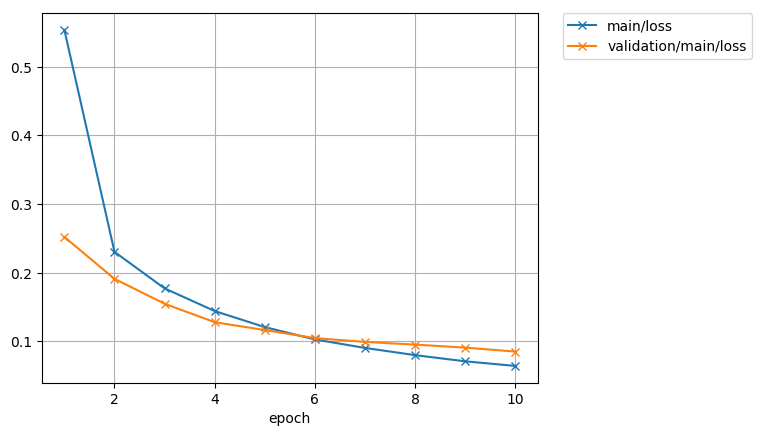

In [9]:
from IPython.display import Image
Image('mnist_result/loss.png')

How about the accuracy?

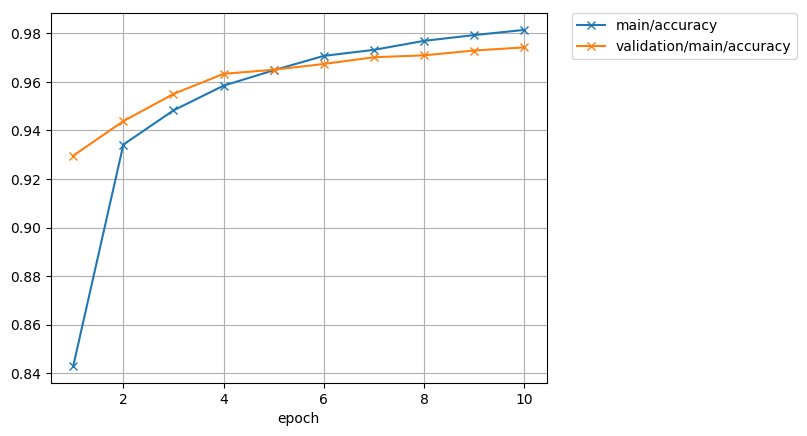

In [10]:
Image('mnist_result/accuracy.png')

Furthermore, let’s visualize the computaional graph saved with dump_graph() using Graphviz.

In [11]:
%%bash
dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

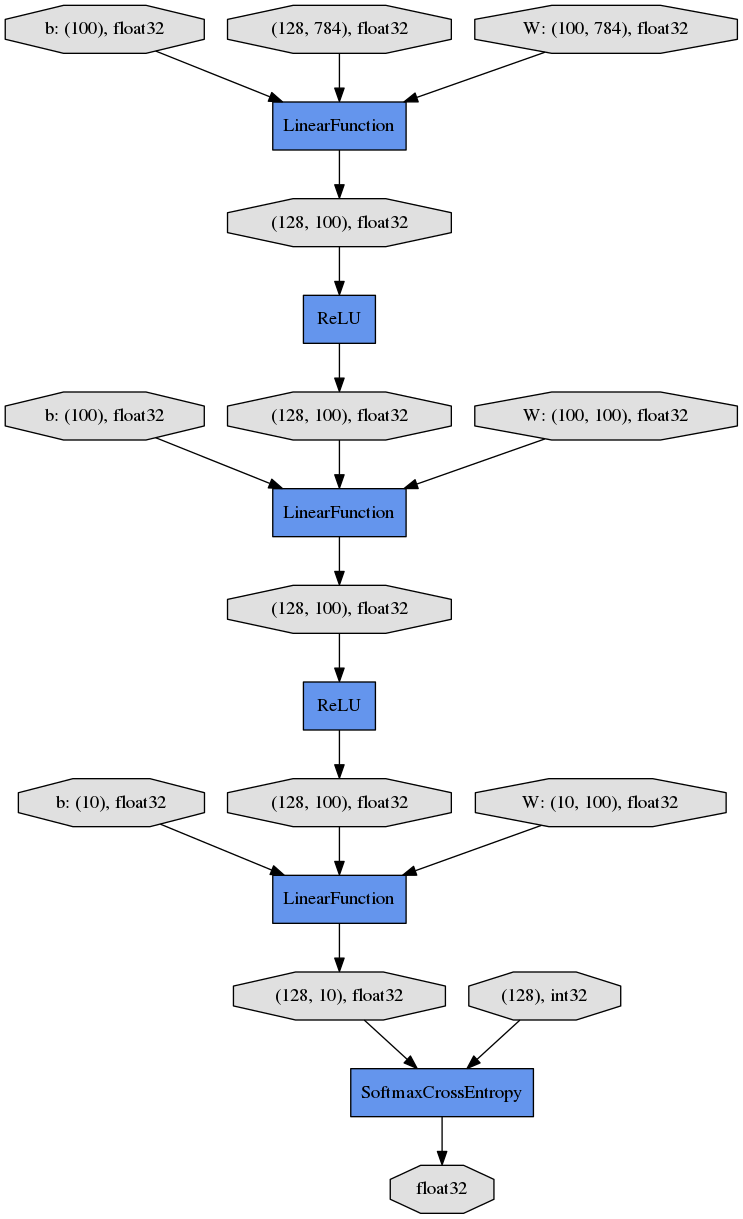

In [12]:
Image('mnist_result/cg.png')

From the top to the bottom, you can see the data flow in the computational graph. It basically shows how data and parameters are passed to the [Function](https://docs.chainer.org/en/latest/reference/core/generated/chainer.Function.html#chainer.Function)s.

# 8. Evaluate a pre-trained model

Evaluation using the snapshot of a model is as easy as what explained in the tutorial/train_loop.rst.

In [13]:
import matplotlib.pyplot as plt

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)

# Show the output
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

y = model(x[None, ...])

print('predicted_label:', y.data.argmax(axis=1)[0])

label: 7
predicted_label: 7


**The prediction looks correct. Yatta!**